In [47]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(1, 10, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv_2 = nn.Conv2d(10, 20, 5)
        self.fc_1 = nn.Linear(20*4*4, 256)
        self.fc_2 = nn.Linear(256, 64)
        self.fc_3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv_1(x)))
        x = self.maxpool(F.relu(self.conv_2(x)))
        # flatten
        x = x.view(-1, 20*4*4)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.log_softmax(self.fc_3(x), dim=1)

        return x

In [48]:
epochs = 25
batch_size = 64
learning_rate = 0.01
momentum = 0.5

In [49]:
transformation = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                    ])

train_data = torch.utils.data.DataLoader(datasets.MNIST(root="./data", train=True, download=True, transform=transformation), batch_size=128, shuffle=True)
test_data = torch.utils.data.DataLoader(datasets.MNIST(root="./data", train=False, download=True, transform=transformation), batch_size=128, shuffle=True)

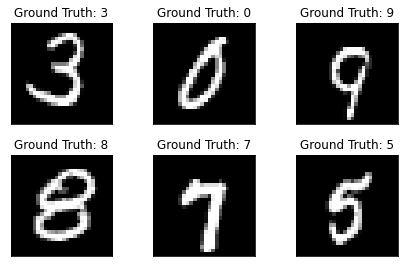

In [59]:
sample = enumerate(train_data)
index, (data_sample, target_sample) = next(sample)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data_sample[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(target_sample[i]))
    plt.xticks([])
    plt.yticks([])

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device=device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.NLLLoss()

ConvNet(
  (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=320, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=10, bias=True)
)


In [61]:
# The following steps are just for getting the input size for the first fc-layer

image, label = next(iter(train_data))

conv_1 = nn.Conv2d(1, 10, 5)
maxpool = nn.MaxPool2d(2, 2)
conv_2 = nn.Conv2d(10, 20, 5)

print(image.shape)
x = conv_1(image)
print(x.shape)
x = maxpool(x)
print(x.shape)
x = conv_2(x)
print(x.shape)
x = maxpool(x)
print(x.shape) # So the input for the first fc layer is 20*4*4




torch.Size([128, 1, 28, 28])
torch.Size([128, 10, 24, 24])
torch.Size([128, 10, 12, 12])
torch.Size([128, 20, 8, 8])
torch.Size([128, 20, 4, 4])


In [62]:
print(f"Length of the trainset: {len(train_data)}")
print(f"Length of the testset: {len(test_data)}")

Length of the trainset: 469
Length of the testset: 79


In [63]:
for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    model.train()
    for x, y in train_data:    
        optimizer.zero_grad()
        x = x.to(device=device)
        y = y.to(device=device)

        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        model.eval()
    with torch.no_grad():
        for x, y in test_data:
            x = x.to(device=device)
            y = y.to(device=device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}\tTrain loss: {train_loss / len(train_data):.4f}\tValidation loss: {test_loss/len(test_data):.4f}")
    print("---------------------------------------------------------------------------")

Epoch 1/25	Train loss: 1.0165	Validation loss: 0.2391
---------------------------------------------------------------------------
Epoch 2/25	Train loss: 0.1855	Validation loss: 0.1311
---------------------------------------------------------------------------
Epoch 3/25	Train loss: 0.1182	Validation loss: 0.0904
---------------------------------------------------------------------------
Epoch 4/25	Train loss: 0.0911	Validation loss: 0.0734
---------------------------------------------------------------------------
Epoch 5/25	Train loss: 0.0762	Validation loss: 0.0632
---------------------------------------------------------------------------
Epoch 6/25	Train loss: 0.0672	Validation loss: 0.0541
---------------------------------------------------------------------------
Epoch 7/25	Train loss: 0.0598	Validation loss: 0.0626
---------------------------------------------------------------------------
Epoch 8/25	Train loss: 0.0537	Validation loss: 0.0479
------------------------------------

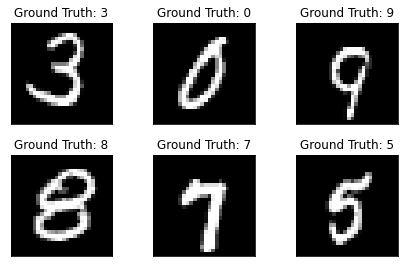

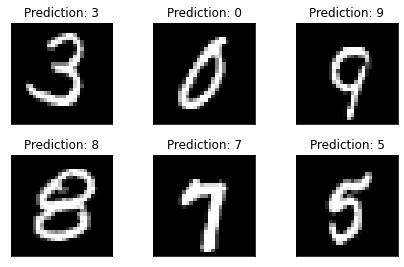

In [64]:
# Check if model predicts the correct numbers regarding the ground truth values

with torch.no_grad():
    if device != 'cpu':
        model = model.to(device='cpu')
    pred = model(data_sample)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data_sample[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(target_sample[i]))
    plt.xticks([])
    plt.yticks([])

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data_sample[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(pred.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

Confusion matrix as array: 
[[ 975    0    1    0    0    0    2    1    1    0]
 [   0 1129    0    1    0    1    0    4    0    0]
 [   0    0 1024    1    1    0    0    5    1    0]
 [   1    0    0 1003    0    3    0    2    1    0]
 [   0    0    1    0  976    0    1    1    1    2]
 [   1    0    0    5    0  883    1    1    1    0]
 [   1    1    0    1    1    7  946    0    1    0]
 [   1    1    4    0    0    0    0 1021    1    0]
 [   1    0    2    3    0    3    0    2  958    5]
 [   1    1    0    2    2    4    0    4    2  993]]
Sum of confusion matrix: 10000


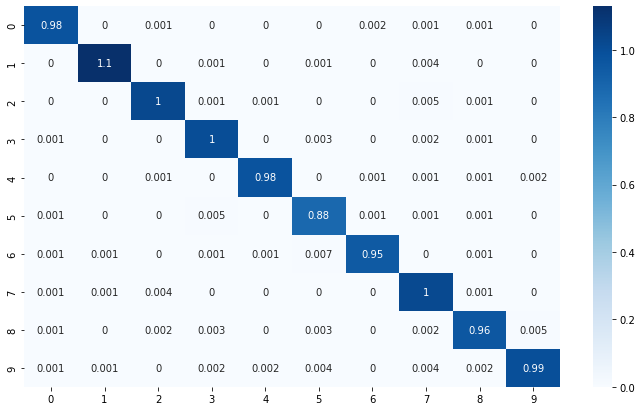

In [65]:
# Simple confusion matrix to display the probability distribution

y_pred = []
y_true = []

for inputs, labels in test_data:
        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
        y_pred.extend(output)
        
        labels = labels.data.numpy()
        y_true.extend(labels)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

cf_matrix = confusion_matrix(y_true, y_pred)
print(f"Confusion matrix as array: \n{cf_matrix}")
print(f"Sum of confusion matrix: {np.sum(cf_matrix)}")
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig('confusion_matrix.png')